## Get the shortest route to cover all the major Landmarks on the Map

Steps to follow:   
- Get the data from BigQuery (Extract Latitude - Longitude information) .  
- Project the latitude Longitude points on the Geomap   .
- Get the data ready for the TSP Algorithms i.e. (x, y) coordinates and distance between them .  
- Pass the data to the Algorithms and get the route covering the Shortest distance .  
- Plot the path onto the map . 


### Getting the data from BigQuery

In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

In [2]:
import math
from TSPAlgos import nearest_neighbor, self_organizing_map, simulated_annealing

**Run just once to get the data locally**

In [3]:
from google.cloud import bigquery
client = bigquery.Client()

sql = """
SELECT DISTINCT start_station_latitude, start_station_longitude 
FROM `bigquery-public-data.new_york.citibike_trips`
"""
df = client.query(sql).to_dataframe()


In [4]:
df.shape

(698, 2)

In [5]:
#Save locally since there are very less data points
df.to_csv('data/nyc_geolocation.csv')

### Exploration

In [3]:
df = pd.read_csv('data/nyc_geolocation.csv')

In [4]:
df = df.iloc[:, 1:]

In [5]:
df.head()

,start_station_latitude,start_station_longitude
0,40.721791,-73.950415
1,40.756604,-73.997901
2,40.718939,-73.992663
3,40.695065,-73.987167
4,40.764618,-73.987895


In [6]:
import geopandas as gpd
from shapely.geometry import Point, Polygon
import descartes

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

In [8]:
geometry = [Point(xy) for xy in zip(df['start_station_longitude'], df['start_station_latitude'])]  #Creates a Point Object that can be plotted
crs = {'init':'epsg:4326'}
geodf = gpd.GeoDataFrame(df, crs=crs, geometry=geometry)  #GeoDataFrame can be plotted on the Map


In [9]:
street_map = gpd.read_file('ShapeFiles/nyu_2451_34505.shp')

In [10]:
geodf['start_station_latitude'].min(), geodf['start_station_latitude'].max()

(40.44535, 40.804213)

In [11]:
import random

In [12]:
take = random.sample(list(range(len(geodf))), 200)

In [13]:
points = geodf.iloc[take].reset_index()

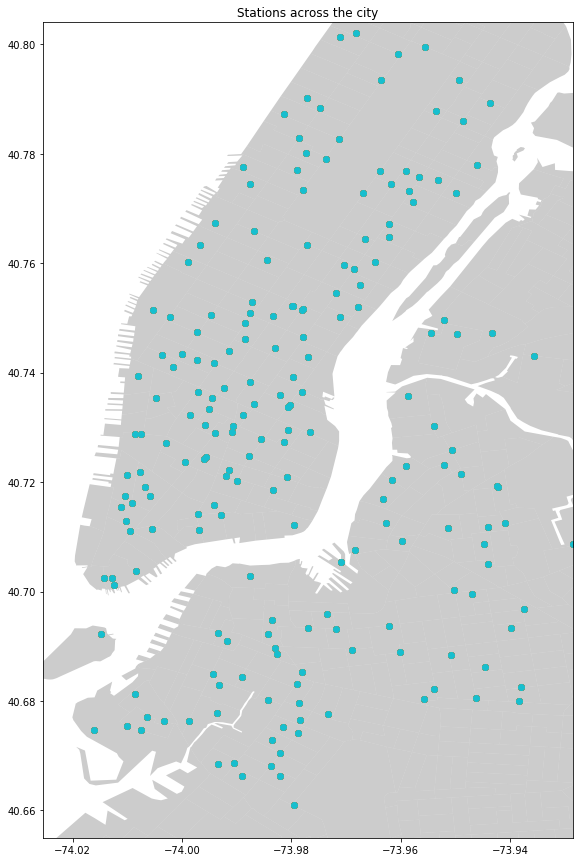

In [14]:
fig, ax = plt.subplots(figsize=(15, 15))
street_map.plot(ax=ax, alpha=0.4, color='grey')

for i in range(len(points)):
    points['geometry'].plot(ax=ax, marker='o')
minx, miny, maxx, maxy = -74.02544975280000, 40.65500, -73.92850399017300, 40.80400
ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)

plt.title('Stations across the city')
plt.show()

## Next Step: converting it to TSP problem, by taking indiviual points as (x, y) and finding distances between them.

In [14]:
def distance(lat1, long1, lat2, long2):
        """
        start_x, start_y, end
        """
        degrees_to_radians = math.pi/180.0
        phi1 = (90.0 - lat1)*degrees_to_radians
        phi2 = (90.0 - lat2)*degrees_to_radians

        theta1 = long1*degrees_to_radians
        theta2 = long2*degrees_to_radians

        a = ((math.sin(phi1)*math.sin(phi2)*math.cos(theta1 - theta2)) +(math.cos(phi1)*math.cos(phi2)))
        if a>1:
            a=0.999999
        dis = math.acos( a )
        return dis*6373


In [15]:
nodes = points.iloc[:, 1:3].values.tolist()

In [16]:
from TSPAlgos import nearest_neighbor, self_organizing_map, simulated_annealing

**Nearest Neighbor Algorithm**

In [22]:
path, shortest_distance = nearest_neighbor.main(nodes)

**Self-Organizing Maps**

In [21]:
path1, shortest_distance1 = self_organizing_map.main(nodes)

**Simulated Annealing Algorithm**

In [17]:
path2, shortest_distance2 = simulated_annealing.main(nodes)

## Trying to plot the path

In [26]:
import geopandas as gpd
from geopandas import GeoDataFrame
from shapely.geometry import LineString
import folium

1. Converting each (x,y) coordinate to Point object . 

In [37]:
vals = []
for i in range(len(path)):
    vals.append(Point(path[i][1], path[i][0]))

In [38]:
toplot = gpd.GeoDataFrame(vals, columns=['geometry'])

In [39]:
toplot.head()

,geometry
0,POINT (-74.01427022999999 40.70251526)
1,POINT (-74.0127234 40.70255065)
2,POINT (-74.01234218 40.70122128)
3,POINT (-74.00838675999999 40.70379920000001)
4,POINT (-74.00944699999999 40.711066)


2. Plotting the stops on the map .  

In [76]:
def add_markers(mapobj, gdf):
    coords = []
    for i, row in gdf.iterrows():
        coords.append([row.geometry.y, row.geometry.x])
    for coord in coords:
        folium.CircleMarker(location = coord,
                            radius = 2.5, 
                            fill = True,
                            fill_color = '#F50057',
                            fill_opacity = 0.75,
                            color = 'whitesmoke',
                            weight = 0.5).add_to(mapobj)
    return mapobj


f = folium.Figure(height = 400)
m = folium.Map([40.7555000, -73.9857400], zoom_start = 12.255, tiles='Cartodb dark_matter',no_wrap=True, max_bounds=True, no_touch=True)
m.add_to(f)

add_markers(m, toplot)


3. Making Line-segments to connect the points on the map that shows the shortest path given by the Algorithm .  

In [60]:
def make_lines(gdf, df_out, i, geometry = 'geometry'):
    geom0 = gdf.loc[i][geometry]
    geom1 = gdf.loc[i + 1][geometry]
    
    start, end = [(geom0.x, geom0.y), (geom1.x, geom1.y)]
    line = LineString([start, end])
    
    # Create a DataFrame to hold record
    data = {'id': i,
            'geometry': [line]}
    df_line = pd.DataFrame(data, columns = ['id', 'geometry'])
    
    # Add record DataFrame of compiled records
    df_out = pd.concat([df_out, df_line])
    return df_out

In [61]:
# initialize an output DataFrame
df = pd.DataFrame(columns = ['id', 'geometry'])

# Loop through each row of the input point GeoDataFrame
x = 0
while x < len(toplot) - 1:
    df = make_lines(toplot, df, x)
    x = x + 1
    
df.head()

,id,geometry
0,0,"LINESTRING (-74.01427022999999 40.70251526, -7..."
0,1,"LINESTRING (-74.0127234 40.70255065, -74.01234..."
0,2,"LINESTRING (-74.01234218 40.70122128, -74.0083..."
0,3,LINESTRING (-74.00838675999999 40.703799200000...
0,4,"LINESTRING (-74.00944699999999 40.711066, -74...."


In [62]:
crs = {'init': 'epsg:4326'}
gdf_line = GeoDataFrame(df, crs=crs)
gdf_line.head()

,id,geometry
0,0,"LINESTRING (-74.01427022999999 40.70251526, -7..."
0,1,"LINESTRING (-74.0127234 40.70255065, -74.01234..."
0,2,"LINESTRING (-74.01234218 40.70122128, -74.0083..."
0,3,LINESTRING (-74.00838675999999 40.703799200000...
0,4,"LINESTRING (-74.00944699999999 40.711066, -74...."


In [77]:
f = folium.Figure(height = 400)
m = folium.Map([40.7555000, -73.9857400], zoom_start = 12.255, tiles='Cartodb dark_matter',no_wrap=True, max_bounds=True, no_touch=True)
m.add_to(f)

add_markers(m, toplot)

folium.GeoJson(gdf_line).add_to(m)
m


**Yeaaaah, finally plotted the points :)**

### Making a Generic function to plot the Shortest paths given by Algorithms

In [24]:
def add_markers(mapobj, gdf):
    coords = []
    for i, row in gdf.iterrows():
        coords.append([row.geometry.y, row.geometry.x])
    for coord in coords:
        folium.CircleMarker(
            location = coord,
            radius = 2.5, 
            fill = True,
            fill_color = '#F50057',
            fill_opacity = 0.75,
            color = 'whitesmoke',
            weight = 0.5).add_to(mapobj)
    return mapobj



def make_lines(gdf, df_out, i, geometry = 'geometry'):
    geom0 = gdf.loc[i][geometry]
    geom1 = gdf.loc[i + 1][geometry]
    
    start, end = [(geom0.x, geom0.y), (geom1.x, geom1.y)]
    line = LineString([start, end])
    
    # Create a DataFrame to hold record
    data = {'id': i,
            'geometry': [line]}
    df_line = pd.DataFrame(data, columns = ['id', 'geometry'])
    
    # Add record DataFrame of compiled records
    df_out = pd.concat([df_out, df_line])
    return df_out



def plot_path(path):
    #converting (x, y) to Point Object
    vals = []
    for i in range(len(path)):
        vals.append(Point(path[i][1], path[i][0]))

    toplot = gpd.GeoDataFrame(vals, columns=['geometry'])

    # initialize an output DataFrame
    df = pd.DataFrame(columns = ['id', 'geometry'])

    # Loop through each row of the input point GeoDataFrame
    x = 0
    while x < len(toplot) - 1:
        df = make_lines(toplot, df, x)
        x = x + 1

    crs = {'init': 'epsg:4326'}
    gdf_line = GeoDataFrame(df, crs=crs)

    f = folium.Figure(height = 400)
    m = folium.Map([40.7555000, -73.9857400], zoom_start = 12.255, \
                   tiles='Cartodb dark_matter',no_wrap=True, max_bounds=True, no_touch=True)
    m.add_to(f)

    add_markers(m, toplot)

    folium.GeoJson(gdf_line).add_to(m)
    return m


### Nearest Neighbor Route

In [27]:
plot_path(path)

### Self Organizing Map Route

In [34]:
plot_path(path1.values.tolist())

### Simulated Annealing Route

In [36]:
plot_path(path2)